# Parameter estimation with MCMC - comparison across strains.

In [1]:
import os
import glob
import pickle
import datetime
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.special
import numba
# Library to perform MCMC runs
import emcee

import sys
sys.path.append(os.path.abspath('../'))
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import seaborn as sns
import corner

# favorite Seaborn settings for notebooks
rc={'lines.linewidth': 2, 
    'axes.labelsize' : 16, 
    'axes.titlesize' : 18,
    'axes.facecolor' : 'F4F3F6',
    'axes.edgecolor' : '000000',
    'axes.linewidth' : 1.2,
    'xtick.labelsize' : 13,
    'ytick.labelsize' : 13,
    'grid.linestyle' : ':',
    'grid.color' : 'a6a6a6'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)
sns.set_palette("deep", color_codes=True)

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Defining the problem

We initally used strain O2 RBS1027 to fit our parameter. Here we would like to extend the analysis to all other strains and look at how each of the parameter estimations compare. Here I perform MCMC using each strain's dataset and calculate the parameter values from each run.

## Bayes theorem as a method for learning

The Bayesian framework gives a natural form on how to solve this issue. Let's focus first on the uncertainty of the repressor. We could write our parameter estimation using Bayes theorem as

\begin{equation}
P(\epsilon_A, \epsilon_I, R \mid D, I) \propto P(D \mid \epsilon_A, \epsilon_I, R, I) \cdot P(\epsilon_A, \epsilon_I, R \mid I),
\end{equation}

where we explicitly included the dependence on the repressor copy number. The second term on the right hand side, the so-called prior, **includes all the information we know before performing the experiment**. For simplicity we can assume that the parameters are independent such that we can rewrite this term as

\begin{equation}
P(\epsilon_A, \epsilon_I, R \mid I) = P(\epsilon_A \mid I) \cdot P(\epsilon_I \mid I) \cdot P(R \mid I).
\end{equation}

Usually one doesn't want to bias the inference with the prior, therefore we are train to use *maximally uniformative priors* for the parameters. So for our previous model we chose a Jeffreys' prior for the $\epsilon_A$ and $\epsilon_I$ parameteres, i.e.

\begin{align}
P(\epsilon_A \mid I) &\propto \frac{1}{\epsilon_A}, \\
P(\epsilon_I \mid I) &\propto \frac{1}{\epsilon_I}
\end{align}

But in a sense Bayes theorem is a *model for learning*. What we mean with that is that it naturally allows us to update our parameter estimates after performing an experiment and obtaining data. So in the case when one doesn't know anything at all about the parameter value these uniformative priors are the right thing to use. 

In order to minimize the data frame parsing that the log-posterior has to do when performing the MCMC let's write a pre-processing function that will parse the data once such that the output can be feed to the log-posterior function.

## MCMC on each dataset.

Let's load data. Ignore this section if you're loading previous chains.

In [2]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + '_IPTG_titration' + '*csv')

ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of unique data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]
# Restart index
df = df.reset_index()

df.head()


Number of unique data-sets: 32


,index,date,username,operator,binding_energy,rbs,repressors,IPTG_uM,mean_YFP_A,mean_YFP_bgcorr_A,fold_change_A
0,2,20160804,mrazomej,O2,-13.9,RBS1L,870,0.0,3624.474605,111.851286,0.007146
1,3,20160804,mrazomej,O2,-13.9,RBS1,610,0.0,3619.786265,107.162946,0.006847
2,4,20160804,mrazomej,O2,-13.9,RBS1027,130,0.0,3717.019527,204.396208,0.013059
3,5,20160804,mrazomej,O2,-13.9,RBS446,62,0.0,3854.650585,342.027265,0.021853
4,6,20160804,mrazomej,O2,-13.9,RBS1147,30,0.0,4169.802851,657.179531,0.041988


Now let's define the function to compute the likelihood, the prior and the posterior probability

In [3]:
def log_likelihood(param, indep_var, dep_var):
    """
    Computes the log likelihood probability.
    Parameteres
    -----------
    param : data-frame.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    epsilon : float.
        Energy difference between the active and inactive state of the repressor.
    Returns
    -------
    log_like : float.
        the log likelihood.
    """
    # unpack parameters
    ea, ei, sigma = param
    #ei =  np.log(1000)+ea 
    
    
    # unpack independent variables
    IPTG, R, epsilon_r = indep_var.iloc[:, 0],\
                         indep_var.iloc[:, 1],\
                         indep_var.iloc[:, 2]
    
    # compute the theoretical fold-change
    fc_theory = mwc.fold_change_log(IPTG, ea, ei,4.5, R, epsilon_r)
   
    log_like =  np.sum((fc_theory - dep_var)**2) / 2 / sigma**2
    return log_like
   
def log_post(param, indep_var, dep_var,
             ea_range=[6 -6], ei_range=[6, -6], sigma_range=[0, 1]):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like.
        The parameters to be fit by the MCMC. This must be an array of length 3
        with the following entries
        param[0] = ea == -lnKa
        param[1] = ei == -lnKi
        param[2] = sigma. Homoscedastic error associated with the Gaussian 
        likelihood.
    indep_var : n x 3 array.
        Series of independent variables to compute the theoretical fold-change.
        1st column : IPTG concentration
        2nd column : repressor copy number
        3rd column : repressor binding energy
    dep_var : array-like
        Dependent variable, i.e. experimental fold-change. Then length of this
        array should be the same as the number of rows in indep_var.
    ea_range : array-like.
        Range of variables to use in the prior as boundaries for the ea parameter.
    ei_range : array-like.
        Range of variables to use in the prior as boundaries for the ei parameter.
    sigma_range : array-like.
        Range of variables to use in the prior as boundaries for the sigma param.
    '''
    # unpack parameters
    ea, ei, sigma = param
    #ei =  np.log(1000) + ea 
    
    # Set the prior boundaries. Since the variables have a Jeffreys prior, in
    # the log probability they have a uniform prior
    if ea > np.max(ea_range) or ea < np.min(ea_range)\
    or ei > np.max(ei_range) or ei < np.min(ei_range)\
    or sigma > np.max(sigma_range) or sigma < np.min(sigma_range):
        return -np.inf

    
    return -(len(indep_var) + 1) * np.log(sigma) \
    - log_likelihood(param, indep_var, dep_var)

In [13]:
groups = df.groupby(['operator', 'rbs'])

for g, subdata in groups:
    df_temp = df[(df.operator == g[0]) & (df.rbs ==  g[1])]
    indep_var = df_temp[['IPTG_uM', 'repressors', 'binding_energy']]
    dep_var = df_temp.fold_change_A
# Perform a non-linear regression
    map_param =  mwc.non_lin_reg_mwc(df_temp, p0=[-5, 2], diss_const=False)
    mean = [map_param[0], map_param[2]]
    cov = np.array([[map_param[1], 0], [0, map_param[3]]])
    
    #Define the parameters for emcee
    n_dim = 3 # number of parameters to fit

    n_walkers = 50
    n_burn = 500
    n_steps = 5000


    # Initialize walkers
    p0 = np.empty((n_walkers, n_dim))
    p0[:,[0, 1]] = np.random.multivariate_normal(mean, cov, n_walkers)
    #p0[:,0] = np.random.uniform(-8, 0.0, n_walkers)
    #p0[:,1] = np.random.uniform(-10, 10,  n_walkers)
    p0[:,2] = np.random.uniform(1E-5, 0.2,  n_walkers)
    
    # Set the ranges for the MCMC
    ea_range = [(map_param[0]-6), (map_param[0]+6)]
    ei_range = [(map_param[2]-6), (map_param[2]+6)]
    sigma_range = [0, df.groupby('rbs').fold_change_A.std().max()]
    #Call the sampler. 
    sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                    args=(indep_var, dep_var, ea_range, ei_range, sigma_range),\
                    threads=6)
    
    #Do the burn in 
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    
    sample = True
    if sample:
        # Perform the real MCMC
        _ = sampler.run_mcmc(pos, n_steps)
        output = open('../../data/mcmc/' + today + \
                      '_error_prop_2_' + g[0] + '_' + g[1] + '.pkl', 'wb')
        pickle.dump(sampler.flatchain, output)
   
    output.close() # close it to make sure it's all been written

KeyError: "['iptg_uM'] not in index"

Lets take a look at one of the strains:

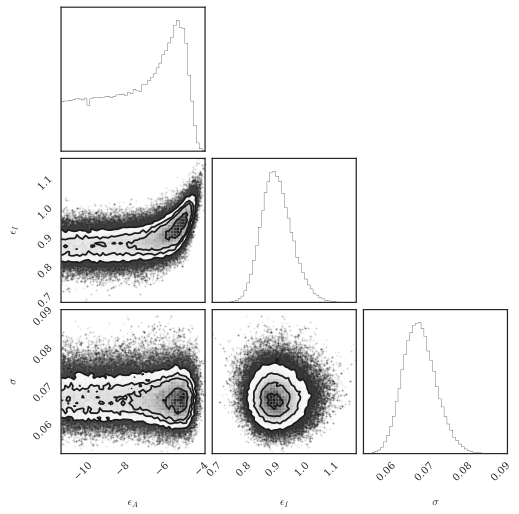

In [88]:
# Load the flat-chain
with open('../../data/mcmc/' + '20160923' + \
                  '_error_prop_2_O2_HG104.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()

# Draw the corner plot
fig = corner.corner(gauss_flatchain, bins=50, 
                    plot_contours=True,
                    labels=[r'$\epsilon_A$', r'$\epsilon_I$', r'$\sigma$'])

### Reporting the results.

To report the output of the MCMC routine we will use the HPD. As explained in [this tutorial](http://bebi103.caltech.edu/2015/tutorials/l06_credible_regions.html)
>This method uses the highest posterior density interval, or HPD. If we're considering a 95% confidence interval, the HPD interval is the shortest interval that contains 95% of the probability of the posterior. So, we report the mode and then the bounds on the HPD interval.

We will use the same funciton used in the tutorial to compute the HPD from the MCMC chain.

Next I want to summarize each prediction for Ka and Ki across all the MCMC fits. Lets save all of these into a dataframe.

In [5]:
# Load the data
with open('../../data/mcmc/' + '20160923' + \
                  '_error_prop_2_O2_RBS1027.pkl', 'rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_pool_flatchain = unpickler.load()
    
# map value of the parameters
ea, ei = np.mean(gauss_pool_flatchain[:, [0, 1]], axis=0)
Ka, Ki = np.exp(-ea), np.exp(-ei)
# ea range
ea_hpd = mwc.hpd(gauss_pool_flatchain[:, 0], 0.95)
ei_hpd = mwc.hpd(gauss_pool_flatchain[:, 1], 0.95)
Ka_hpd = np.exp(-ea_hpd)
Ki_hpd = np.exp(-ei_hpd)

# Print results
print("""
The most probable parameters for the MWC model
----------------------------------------------
Ka = {0:.2f} +{1:0.3f} -{2:0.3f} uM
Ki = {3:.5f} +{4:0.6f} -{5:0.6f} uM
""".format(Ka, np.abs(Ka-Ka_hpd[0]), np.abs(Ka-Ka_hpd[1]),\
           Ki,np.abs(Ki-Ki_hpd[0]), np.abs(Ki-Ki_hpd[1])))


The most probable parameters for the MWC model
----------------------------------------------
Ka = 141.78 +28.702 -22.775 uM
Ki = 0.56086 +0.045257 -0.041159 uM



# Plotting the credible region using the MCMC traces.

Now that we not only know the MAP value of the MWC parameters, but also the credible intervals for them we can properly reflect that uncertainty on our plots.

Drawing a proper credible region on the fold-change curve is not as straight forwared as taking both lower and upper boundaries of the HPD and plotting these values since, as shown in the MCMC trace plot the paraemeters are clearly correlated. But we can take advantage of the MCMC traces to compute the proper credible intevals.



In [2]:
def mcmc_cred_region(IPTG, flatchain, R, epsilon_r,
                     mass_frac=.95, epsilon=4.5):
    '''
    This function takes every element in the MCMC flatchain and computes the
    fold-change for each IPTG concentration returning at the end the indicated
    mass_frac fraction of the fold change.
    Parameters
    ----------
    IPTG : array-like.
        IPTG concentrations on which evaluate the fold change
    flatchain : array-like.
        MCMC traces for the two MWC parameteres.
        flatchain[:,0] = ea flat-chain
        flatchain[:,1] = ei flat-chain
    R : float.
        Mean repressor copy number.
    epsilon_r : float.
        Repressor binding energy.
    mass_frac : float with 0 < mass_frac <= 1
        The fraction of the probability to be included in
        the HPD.  For example, `massfrac` = 0.95 gives a
        95% HPD.
    epsilon : float.
        Energy difference between active and inactive state.
    Returns
    -------
    cred_region : array-like
        array of 2 x len(IPTG) with the upper and the lower fold-change HPD 
        bound for each IPTG concentration
    '''
    # initialize the array to save the credible region
    cred_region = np.zeros([2, len(IPTG)])
    
    # loop through IPTG concentrations, compute all the fold changes and
    # save the HPD for each concentration
    for i, c in enumerate(IPTG):
        fc = mwc.fold_change_log(c, flatchain[:,0], flatchain[:, 1], epsilon,
                                R, epsilon_r)
        cred_region[:, i] = mwc.hpd(fc, mass_frac)
    
    return cred_region

Lets load in the data for our plots.

In [52]:
datadir = '../../data/'
# read the list of data-sets to ignore
data_ignore = pd.read_csv(datadir + 'datasets_ignore.csv', header=None).values
# read the all data sets except for the ones in the ignore list
all_files = glob.glob(datadir + '*' + '_IPTG_titration' + '*csv')
ignore_files = [f for f in all_files for i in data_ignore if i[0] in f]
read_files = [f for f in all_files if f not in ignore_files]
print('Number of unique data-sets: {:d}'.format(len(read_files)))
df = pd.concat(pd.read_csv(f, comment='#') for f in read_files)

# Now we remove the autofluorescence and delta values
df = df[(df.rbs != 'auto') & (df.rbs != 'delta')]
# Restart index
df = df.reset_index()

df.head()

Number of unique data-sets: 33


,index,IPTG_uM,area,binding_energy,date,eccentricity,fold_change_A,mean_YFP_A,mean_YFP_bgcorr_A,mean_intensity,operator,rbs,repressors,solidity,username
0,2,0.0,NaN,-13.9,20160804,NaN,0.007146,3624.474605,111.851286,NaN,O2,RBS1L,870,NaN,mrazomej
1,3,0.0,NaN,-13.9,20160804,NaN,0.006847,3619.786265,107.162946,NaN,O2,RBS1,610,NaN,mrazomej
2,4,0.0,NaN,-13.9,20160804,NaN,0.013059,3717.019527,204.396208,NaN,O2,RBS1027,130,NaN,mrazomej
3,5,0.0,NaN,-13.9,20160804,NaN,0.021853,3854.650585,342.027265,NaN,O2,RBS446,62,NaN,mrazomej
4,6,0.0,NaN,-13.9,20160804,NaN,0.041988,4169.802851,657.179531,NaN,O2,RBS1147,30,NaN,mrazomej


In [4]:
# Define a few functions that will clean up our plot
# http://www.jesshamrick.com/2016/04/13/reproducible-plots/

def set_style():
    # This sets reasonable defaults for font size for
    # a figure that will go in a paper
    sns.set_context("paper")
    
    # Set the font to be serif, rather than sans
    sns.set(font='serif')
    
    # Make the background white, and specify the
    # specific font family
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
            spine.set_smart_bounds(True)
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

Lets generate a grid of plots across all strains and strain-specific parameters (for a single operator).

In [53]:
# Pick operator to look at.
df = df[df['operator']=='O2']

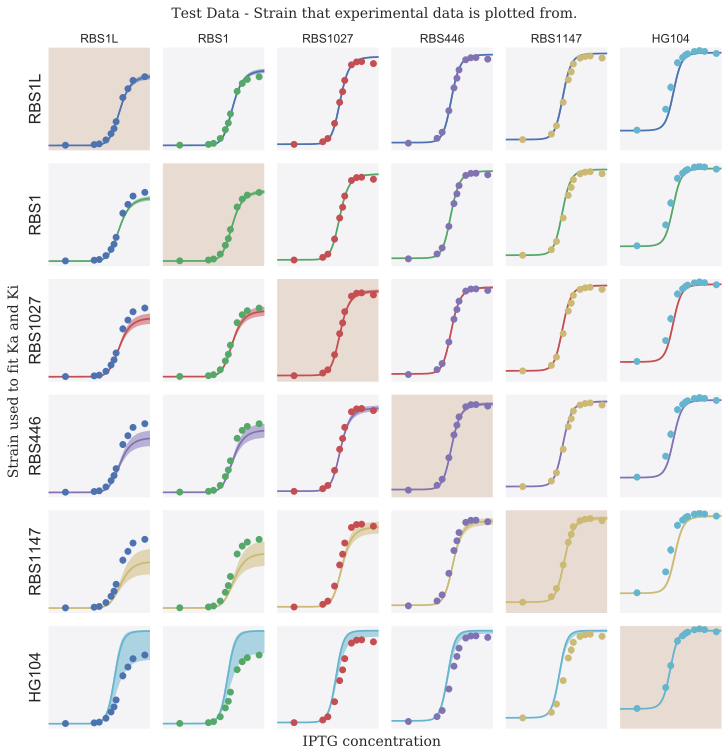

In [5]:
# Define array of IPTG concentrations
IPTG = np.logspace(-8, -2, 200)

# current default color palette; we can change this.
colors = sns.color_palette(n_colors=8)

fig, ax = plt.subplots(nrows=6, ncols=6,sharex=True, sharey=True, figsize=(10,10))
set_style()

count = 1
for j, rbs_fit in enumerate(df.rbs.unique()):
    
    with open('../../data/mcmc/' + '20160923' + \
          '_error_prop_2_' + 'O2' + '_' + rbs_fit + '.pkl', 'rb') as file:
        unpickler = pickle.Unpickler(file)
        gauss_pool_flatchain = unpickler.load()
    
    # map value of the parameters
    ea, ei = np.mean(gauss_pool_flatchain[:, [0, 1]], axis=0)

    for i, rbs in enumerate(df.rbs.unique()):
        # plot the theory using the parameters from the fit.
        ax[j,i].plot(IPTG , mwc.fold_change_log(IPTG * 1E6, 
            ea=ea, ei=ei, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=-13.9),
            color=colors[j])
        # plot 95% HPD region using the variability in the MWC parameters
        cred_region = mcmc_cred_region(IPTG * 1E6, 
            gauss_pool_flatchain, epsilon=4.5,
            R=df[(df.rbs == rbs)].repressors.unique(),
            epsilon_r=-13.9)
        ax[j,i].fill_between(IPTG , cred_region[0,:], cred_region[1,:],
                        alpha=0.5, color=colors[j])
        # compute the mean value for each concentration
        fc_mean = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.mean()
        # compute the standard error of the mean
        fc_err = df[df.rbs==rbs].groupby('IPTG_uM').fold_change_A.std() / \
        np.sqrt(df[df.rbs==rbs].groupby('IPTG_uM').size())

        # plot the experimental data
        ax[j,i].errorbar(np.sort(df[df.rbs==rbs].IPTG_uM.unique()) / 1E6, fc_mean,
            yerr=fc_err,
            fmt='o', label=rbs, color=colors[i])
                # place background color to distinguish the data that is 
        # plotted with fitted curve
        if i==j:
            ax[j,i].set_axis_bgcolor("#E8DCD2")
        if i == 0:
            ax[j,i].set_ylabel(rbs_fit)
        if j == 0:
            ax[j,i].set_title(rbs)
        
        # Hide the spines
        adjust_spines(ax[j,i], [])
        ax[j,i].get_xaxis().set_visible(False)
        
        plt.xscale('log')
        plt.ylim(-0.05,1.05)

fig.text(-0.01, 0.5, 'Strain used to fit Ka and Ki', va='center', rotation='vertical',fontsize=14)
fig.text(0.4, -0.01, 'IPTG concentration', va='bottom',fontsize=14)
fig.suptitle('Test Data - Strain that experimental data is plotted from.',fontsize=14,y=1.02)
fig.subplots_adjust(hspace=0.05, wspace=0.05) 
fig.tight_layout()
#plt.savefig('../../data/mcmc/' + '20160923' + \
#          '_fitcompare_summary' + 'O2' + '.pdf',bbox_inches='tight')

Lets summarize the Ka, Ki, and hpd values from the MCMC runs for each rbs strain. Remember that this is only for the operator considered above. Reload the data to get the other operators.

In [55]:
param_summary = pd.DataFrame(columns=['rbs','operator', 'Ka', 'Ka_hpd_left',
                                      'Ka_hpd_right', 'Ki', 'Ki_hpd_left',
                                     'Ki_hpd_right'])
groups = df.groupby(['operator', 'rbs'])

for g, subdata in groups:
    with open('../../data/mcmc/' + '20160923' + \
              '_error_prop_2_' + g[0] + '_' + g[1] + '.pkl', 'rb') as file:
        unpickler = pickle.Unpickler(file)
        gauss_pool_flatchain = unpickler.load()
    
    # map value of the parameters
    ea, ei = np.mean(gauss_pool_flatchain[:, [0, 1]], axis=0)
    Ka, Ki = np.exp(-ea), np.exp(-ei)

    # ea range
    ea_hpd = mwc.hpd(gauss_pool_flatchain[:, 0], 0.95)
    ei_hpd = mwc.hpd(gauss_pool_flatchain[:, 1], 0.95)
    Ka_hpd = np.exp(-ea_hpd)
    Ki_hpd = np.exp(-ei_hpd)
              
    # add values to dataframe
    param_summary_temp = pd.DataFrame({'rbs':g[1],'operator':g[0],
                                   'Ka':[Ka],
                                   'Ka_hpd_error_left':[np.abs(Ka-Ka_hpd[0])], 
                                   'Ka_hpd_error_right':[np.abs(Ka-Ka_hpd[1])],
                                   'Ki':[Ki],
                                   'Ki_hpd_error_left':[np.abs(Ki-Ki_hpd[0])], 
                                   'Ki_hpd_error_right':[np.abs(Ki-Ki_hpd[1])]})

    param_summary = param_summary.append(param_summary_temp, ignore_index=True)

In [74]:
param_summary.head()

,Ka,Ka_hpd_error_left,Ka_hpd_error_right,Ka_hpd_left,Ka_hpd_right,Ki,Ki_hpd_error_left,Ki_hpd_error_right,Ki_hpd_left,Ki_hpd_right,operator,rbs
0,1326.712030,47091.627901,1240.867424,NaN,NaN,0.400505,0.042119,0.040890,NaN,NaN,O2,HG104
1,153.576445,17.727178,15.785237,NaN,NaN,0.545640,0.041126,0.036588,NaN,NaN,O2,RBS1
2,141.776653,28.701752,22.774796,NaN,NaN,0.560856,0.045257,0.041159,NaN,NaN,O2,RBS1027
3,133.901420,64.287240,40.667379,NaN,NaN,0.692064,0.084758,0.077417,NaN,NaN,O2,RBS1147
4,198.845765,32.442538,27.065436,NaN,NaN,0.600248,0.060719,0.056837,NaN,NaN,O2,RBS1L


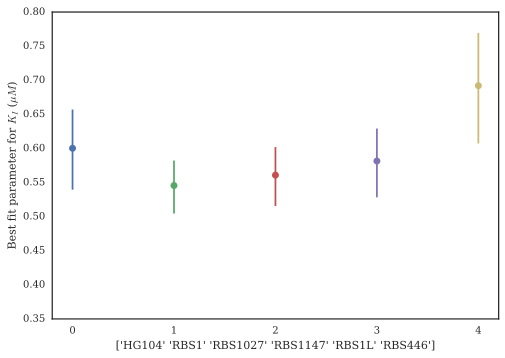

In [75]:
for i, rbs in enumerate(df.rbs.unique()):
    plt.errorbar(i,param_summary[param_summary['rbs']==rbs].Ki,
            yerr=[param_summary[param_summary['rbs']==rbs].Ki_hpd_error_left,
             param_summary2[param_summary2['rbs']==rbs].Ki_hpd_error_right],
            fmt='o', color=colors[i])
plt.xlim(-0.2,4.2)
plt.xlabel(param_summary2.rbs.unique())
plt.ylabel('Best fit parameter for $K_I$ ($\mu M$)')
#plt.savefig('../../data/mcmc/' + '20160923' + \
#          '_error_prop_2_summary' + 'O2_Ki' + '.pdf')

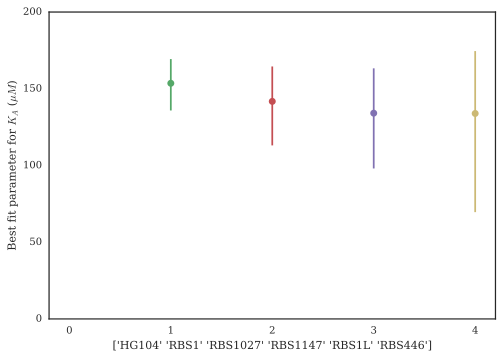

In [76]:
for i, rbs in enumerate(df.rbs.unique()):
    #Ignore HG104 for now.
    if i == 0:
        continue
    plt.errorbar(i,param_summary[param_summary['rbs']==rbs].Ka,
            yerr=[param_summary[param_summary['rbs']==rbs].Ka_hpd_error_left,
             param_summary[param_summary2['rbs']==rbs].Ka_hpd_error_right],
            fmt='o', color=colors[i])
plt.xlim(-0.2,4.2)
plt.ylim(0,200)
plt.xlabel(param_summary2.rbs.unique())
plt.ylabel('Best fit parameter for $K_A$ ($\mu M$)')
#plt.savefig('../../data/mcmc/' + '20160923' + \
#          '_error_prop_2_summary' + 'O2_Ka' + '.pdf')